##Model from https://www.kaggle.com/markwijkhuizen/advanced-image-cleaning-and-tfrecord-generation

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Kaggle

/content/drive/MyDrive/Kaggle


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from multiprocessing import cpu_count
from tqdm.notebook import tqdm

import cv2
import imageio
import joblib
import os
import pickle

tqdm.pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Train/Test DataFrames

In [ ]:
# Mean ratio of first 10K images is 1.73, this image width/height result in a ratio of 1.75
DEBUG = False
IMG_HEIGHT = 256
IMG_WIDTH = 448
VAL_SIZE = int(100) if DEBUG else int(100e3) # 100K validation molecules
CHUNK_SIZE = 2500 # to get ~100MB TFRecords

MAX_INCHI_LEN = 200 # maximum InChI length to prevent to much padding

In [ ]:
if DEBUG:
    train = pd.read_csv('train_labels.csv', dtype={ 'image_id': 'string', 'InChI': 'string' }).head(int(1e3))
else:
    train = pd.read_csv('train_labels.csv', dtype={ 'image_id': 'string', 'InChI': 'string' })

# Drop all InChI longer than MAX_INCHI_LEN - 2,  <start>InChI <end>, remove 'InChI=1S/' at start
train['InChI_len'] = train['InChI'].apply(len).astype(np.uint16)
train = train.loc[train['InChI_len'] <= MAX_INCHI_LEN - 2 + 9].reset_index(drop=True)

In [ ]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2371184 entries, 0 to 2371183
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   image_id   string
 1   InChI      string
 2   InChI_len  uint16
dtypes: string(2), uint16(1)
memory usage: 40.7 MB
None


In [ ]:
display(train.head(3))

,image_id,InChI,InChI_len
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...,81
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...,155
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...,158


In [ ]:
if DEBUG:
    test = pd.read_csv('sample_submission.csv', 
                       usecols=['image_id'], dtype={ 'image_id': 'string' }).head(int(1e3))
else:
    test = pd.read_csv('sample_submission.csv', 
                       usecols=['image_id'], dtype={ 'image_id': 'string' })

In [ ]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1616107 entries, 0 to 1616106
Data columns (total 1 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   image_id  1616107 non-null  string
dtypes: string(1)
memory usage: 12.3 MB
None


In [ ]:
display(test.head(3))

,image_id
0,00000d2a601c
1,00001f7fc849
2,000037687605


# Vocabulary

In [ ]:
def get_vocabulary():
    tokens = ['<start>', '<end>', '<pad>']
    vocabulary = set()
    for s in tqdm(train['InChI'].values):
        vocabulary.update(s)
    return tokens + list(vocabulary)

vocabulary = get_vocabulary()

In [ ]:
# Save vocabulary mappings
# character -> integer
vocabulary_to_int = dict(zip(vocabulary, np.arange(len(vocabulary), dtype=np.int8)))
with open('vocabulary_to_int.pkl', 'wb') as handle:
    pickle.dump(vocabulary_to_int, handle)

#  integer -> character
int_to_vocabulary = dict(zip(np.arange(len(vocabulary), dtype=np.int8), vocabulary))
with open('int_to_vocabulary.pkl', 'wb') as handle:
    pickle.dump(int_to_vocabulary, handle)

In [ ]:
# Remove the "InChI=1S/" part from the InChI strings
# It is equal for all InChI's, thus redundant
train['InChIClean'] = train['InChI'].apply(lambda InChI: '/'.join(InChI.split('=')[1].split('/')[1:]))

In [ ]:
# convert the InChI strings to integer lists
# start/end/pad tokens are used
def inchi_str2int(InChI):
    res = []
    res.append(vocabulary_to_int.get('<start>'))
    for c in InChI:
        res.append(vocabulary_to_int.get(c))
    
    res.append(vocabulary_to_int.get('<end>'))
    while len(res) < MAX_INCHI_LEN: 
        res.append(vocabulary_to_int.get('<pad>'))
        
    return np.array(res, dtype=np.uint8)
        
train['InChI_int'] = train['InChIClean'].progress_apply(inchi_str2int)

# Train Val Split

In [ ]:
train_mini = train[train['image_id'].str.match('0')]

In [ ]:
test_mini = test[test['image_id'].str.match('0')]

In [ ]:
VAL_SIZE = 10000

In [ ]:
val = train_mini.iloc[-VAL_SIZE:].reset_index(drop=True)
train = train_mini.iloc[:-VAL_SIZE].reset_index(drop=True)
N_IMGS = len(train)

In [ ]:
pd.options.display.max_colwidth = 100
display(train.head(3))

,image_id,InChI,InChI_len,InChIClean,InChI_int
0,000011a64c74,"InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12(13)11(4)14/h5-7,9,11,14H,8H2,1-4H3",81,"C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12(13)11(4)14/h5-7,9,11,14H,8H2,1-4H3","[0, 4, 19, 12, 36, 29, 6, 8, 18, 9, 30, 19, 20, 23, 40, 29, 24, 13, 20, 19, 26, 20, 19, 12, 20, ..."
1,000019cc0cd2,"InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(10-14)11-17(23)19-15-4-5-18(24)21(15,3)9-7-16(19)20...",155,"C21H30O4/c1-12(22)25-14-6-8-20(2)13(10-14)11-17(23)19-15-4-5-18(24)21(15,3)9-7-16(19)20/h13-16,1...","[0, 4, 29, 19, 36, 12, 6, 8, 25, 9, 30, 19, 20, 19, 29, 40, 29, 29, 24, 29, 26, 20, 19, 25, 20, ..."
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-12-10-20(28)30)27-11-9-16-21(23(25)31)26-29(22(16)2...,158,C24H23N5O4/c1-14-13-15(7-8-17(14)28-12-10-20(28)30)27-11-9-16-21(23(25)31)26-29(22(16)24(27)32)1...,"[0, 4, 29, 25, 36, 29, 12, 31, 26, 8, 25, 9, 30, 19, 20, 19, 25, 20, 19, 12, 20, 19, 26, 40, 27,..."


In [ ]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138344 entries, 0 to 138343
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   image_id    138344 non-null  string
 1   InChI       138344 non-null  string
 2   InChI_len   138344 non-null  uint16
 3   InChIClean  138344 non-null  object
 4   InChI_int   138344 non-null  object
dtypes: object(2), string(2), uint16(1)
memory usage: 4.5+ MB
None


In [ ]:
print(val.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    10000 non-null  string
 1   InChI       10000 non-null  string
 2   InChI_len   10000 non-null  uint16
 3   InChIClean  10000 non-null  object
 4   InChI_int   10000 non-null  object
dtypes: object(2), string(2), uint16(1)
memory usage: 332.2+ KB
None


# Image Cleaning

In [ ]:
def remove_blobs(img, min_size=10, debug=False):
    if debug:
        fig, ax = plt.subplots(1,2, figsize=(30,8))
        ax[0].imshow(img)
        ax[0].set_title('original image', size=16)
    
    height, width = img.shape

    # find all the connected components (white blobs in your image)
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=8)
    # Removes background, which is seen as a big component
    sizes = stats[1:, -1]
  
    blob_idxs = []    
    for idx, s in enumerate(sizes):
        if s < min_size:
            blob_idxs.append(idx+1)
    
    img[np.isin(output, blob_idxs)] = 0
    
    if debug:
        ax[1].imshow(img)
        ax[1].set_title('image with removed blobs', size=16)
        plt.show()
    
    return img

In [ ]:
def crop(img, debug=False):
    if debug:
        fig, ax = plt.subplots(1,2, figsize=(30,8))
        ax[0].imshow(img)
        ax[0].set_title(f'original image, shape: {img.shape}', size=16)
        
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]
    
    x_min, y_min, x_max, y_max = np.inf, np.inf, 0, 0
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        x_min = min(x_min, x)
        y_min = min(y_min, y)
        x_max = max(x_max, x + w)
        y_max = max(y_max, y + h)

    img_cropped = img[y_min:y_max, x_min:x_max]
    
    if debug:
        ax[1].imshow(img_cropped)
        ax[1].set_title(f'cropped image, shape: {img_cropped.shape}', size=16)
        plt.show()
    
    return img_cropped

In [ ]:
# pad the kernels to create squares, max_pad can be used to create rectangles
def pad_kernel(kernel, max_pad=np.inf):
    kernel = np.array(kernel)
    h, w = kernel.shape
    pad_h = min((max(h, w) - h) // 2, max_pad)
    pad_w = min((max(h, w) - w) // 2, max_pad)
    return np.pad(kernel, ([pad_h, pad_h], [pad_w, pad_w]), 'constant', constant_values=-1)

# creates a mask of missing pixels to be filled using
def create_mask(kernel, img_b):
    mask = cv2.filter2D(img_b, -1, kernel)
    kernel_flat_sum = (kernel == a).flatten().sum()
    threshold_min = kernel_flat_sum * threshold_ratio
    threshold_max = kernel_flat_sum + 1
    return (mask > threshold_min) & (mask < threshold_max)

# make kernels
a = np.float32(1.0 / 255.0)
threshold_ratio = 0.50
# single pixel width horizontal line with 1 pixel missing
kernel_h_single_mono = pad_kernel([
    [ a, a,  a, -1,  a,  a, a ]
], max_pad=1)
# single pixel width horizontal line with 3 pixels missing
kernel_h_single_triple = pad_kernel([
    [ a, a, a, -1, -1, -1, a, a, a ]
], max_pad=1)

kernel_h_multi = pad_kernel([
    [ a, a, a, a, a, a, a ],
    [ a, a, a,-1, a, a, a ],
    [ a, a, a, a, a, a, a ],
], max_pad=1)

kernel_v_single = pad_kernel([
    [ a],
    [ a],
    [ a],
    [-1],
    [ a],
    [ a],
    [ a],
], max_pad=1)

kernel_v_multi = pad_kernel([
    [ a, a, a ],
    [ a, a, a ],
    [ a, a, a ],
    [ a,-1, a ],
    [ a, a, a ],
    [ a, a, a ],
    [ a, a, a ],
], max_pad=1)

kernel_lr_single = pad_kernel([
    [ -1,-1,-1,-1, a ],
    [ -1,-1,-1, a,-1 ],
    [ -1,-1,-1,-1,-1 ],
    [ -1, a,-1,-1,-1 ],
    [  a,-1,-1,-1,-1 ],
])

kernel_lr_multi = pad_kernel([
    [ -1,-1,-1, a, a ],
    [ -1,-1, a, a, a ],
    [ -1, a,-1, a,-1 ],
    [  a, a, a,-1,-1 ],
    [  a, a,-1,-1,-1 ],
])

kernel_rl_single = pad_kernel([
    [  a,-1,-1,-1,-1 ],
    [ -1, a,-1,-1,-1 ],
    [ -1,-1,-1,-1,-1 ],
    [ -1,-1,-1, a,-1 ],
    [ -1,-1,-1,-1, a ],
])

kernel_rl_multi = pad_kernel([
    [ a, a,-1,-1,-1],
    [ a, a, a,-1,-1],
    [-1, a,-1, a,-1],
    [-1,-1, a, a, a],
    [-1,-1,-1, a, a],
])

def fill_missing_pixels(img, debug):
    img_b = img.astype(np.float32)
    img_b[img_b > 0] = 255

    mask_h_single_mono = create_mask(kernel_h_single_mono, img_b)

    mask_h_single_triple = create_mask(kernel_h_single_triple, img_b)

    mask_h_single = mask_h_single_mono | mask_h_single_triple

    mask_h_multi = create_mask(kernel_h_multi, img_b)


    mask_v_single = create_mask(kernel_v_single, img_b)


    mask_v_multi = create_mask(kernel_v_multi, img_b)


    mask_lr_single = create_mask(kernel_lr_single, img_b)


    mask_lr_multi = create_mask(kernel_lr_multi, img_b)


    mask_rl_single = create_mask(kernel_lr_single, img_b)


    mask_rl_multi = create_mask(kernel_rl_multi, img_b)

    mask_single = mask_h_single | mask_v_single | mask_lr_single | mask_rl_single
    mask_multi = mask_h_multi  | mask_v_multi |mask_lr_multi | mask_rl_multi
    mask = mask_single | mask_multi

    if debug:
        fig, ax = plt.subplots(2, 2 ,figsize=(35,20))
        ax[0,0].imshow(mask_h_single)
        ax[0,0].set_title('mask_h_single', size=16)
        ax[0,1].imshow(mask_v_single)
        ax[0,1].set_title('mask_v_single', size=16)
        ax[1,0].imshow(mask_lr_single)
        ax[1,0].set_title('mask_lr_single', size=16)
        ax[1,1].imshow(mask_lr_single)
        ax[1,1].set_title('mask_lr_single', size=16)
        plt.show()

        fig, ax = plt.subplots(2, 2, figsize=(35,20))
        ax[0,0].imshow(mask_h_multi)
        ax[0,0].set_title('mask_h_multi', size=16)
        ax[0,1].imshow(mask_v_multi)
        ax[0,1].set_title('mask_v_multi', size=16)
        ax[1,0].imshow(mask_lr_multi)
        ax[1,0].set_title('mask_lr_multi', size=16)
        ax[1,1].imshow(mask_rl_multi)
        ax[1,1].set_title('mask_rl_multi', size=16)
        plt.show()

        fig, ax = plt.subplots(2, 1 ,figsize=(15,20))
        ax[0].imshow(img)
        ax[0].set_title('original image', size=16)

        img_fill = mask.copy()
        img_fill[img_fill > 0] = 255

        img_rgb = np.stack([
            img_fill,
            img_b,
            np.zeros(img.shape),
        ], axis=2)

        ax[1].imshow(img_rgb)
        ax[1].set_title('image with filled missing pixels (red)', size=16)
        plt.show()    

    # all pixels in the mask are filled up
    img[mask] = 255

    return img

In [ ]:
def pad_resize(img):
    h, w = img.shape
    s = max(w, h)
    pad_h, pad_v = 0, 0
    hw_ratio = (h / w) - (IMG_HEIGHT / IMG_WIDTH)
    if hw_ratio < 0:
        pad_h = int(abs(hw_ratio) * w / 2)
    else:
        wh_ratio = (w / h) - (IMG_WIDTH / IMG_HEIGHT)
        pad_v = int(abs(wh_ratio) * h // 2)

    img = np.pad(img, [(pad_h, pad_h), (pad_v, pad_v)], mode='constant')
    img = cv2.resize(img,(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)

    return img

In [ ]:
def process_img(image_id, folder='train', debug=False):
    # read image and invert colors to get black background and white molecule
    file_path =  f'/content/drive/MyDrive/Kaggle/{folder}/{image_id[0]}/{image_id[1]}/{image_id[2]}/{image_id}.png'
    img0 = 255 - cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    
    # rotate counter clockwise to get horizontal images
    h, w = img0.shape
    if h > w:
        img0 = np.rot90(img0)
    
    # remove blobs, crop, fill missing pixels, pad and resize
    img = remove_blobs(img0, min_size=2, debug=debug)
    img = crop(img, debug=debug)
    img = fill_missing_pixels(img, debug=debug)
    img = pad_resize(img)
    
    if debug:
        fig, ax = plt.subplots(1, 2, figsize=(20,10))
        ax[0].imshow(img0)
        ax[0].set_title('Original image', size=16)
        ax[1].imshow(img)
        ax[1].set_title('Fully processed image', size=16)
    
    # normalize to range 0-255 and encode as png
    img = (img / img.max() * 255).astype(np.uint8)
    img = cv2.imencode('.png', img)[1].tobytes()

    return img

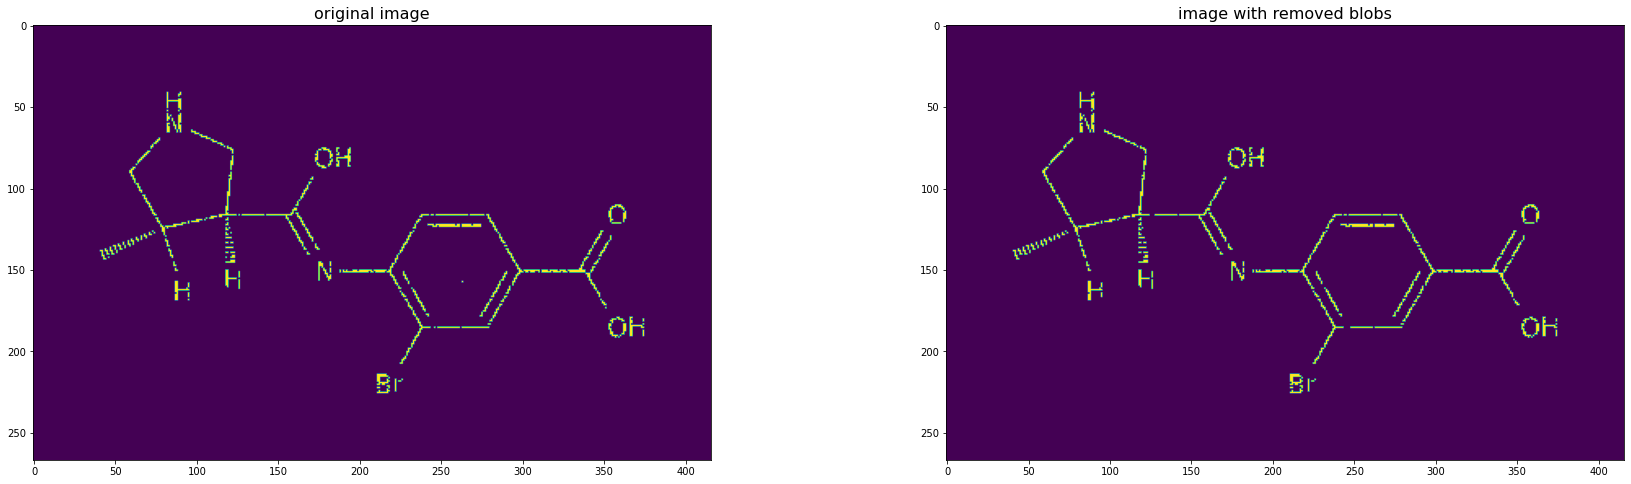

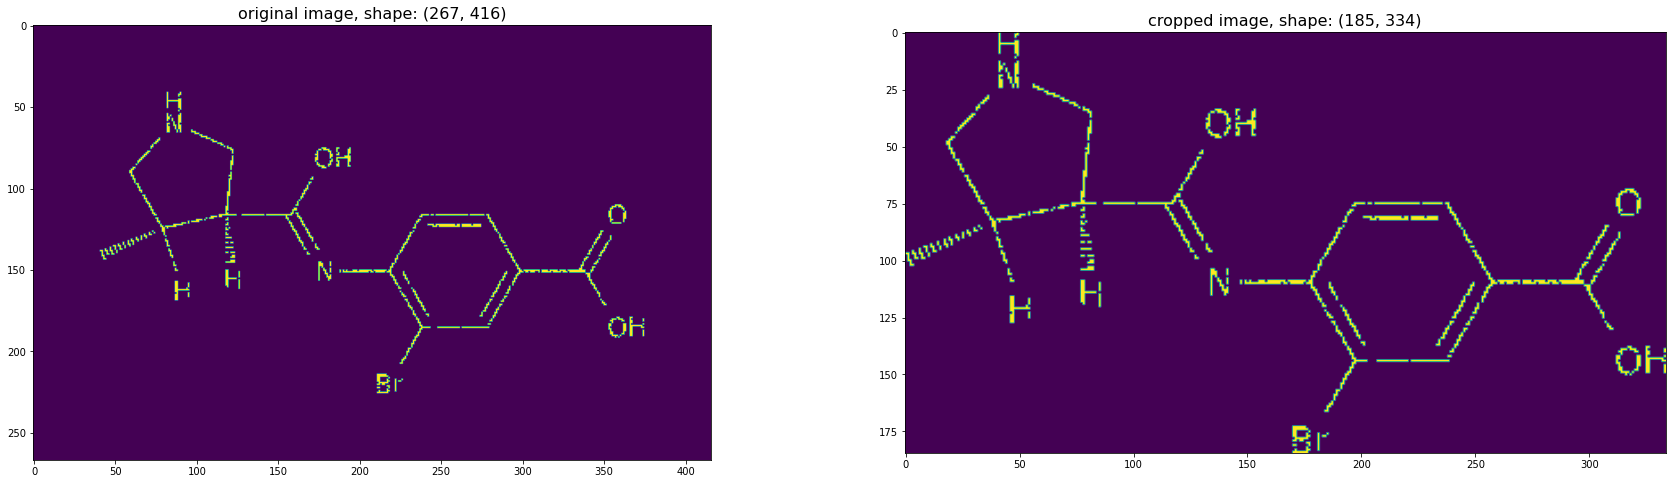

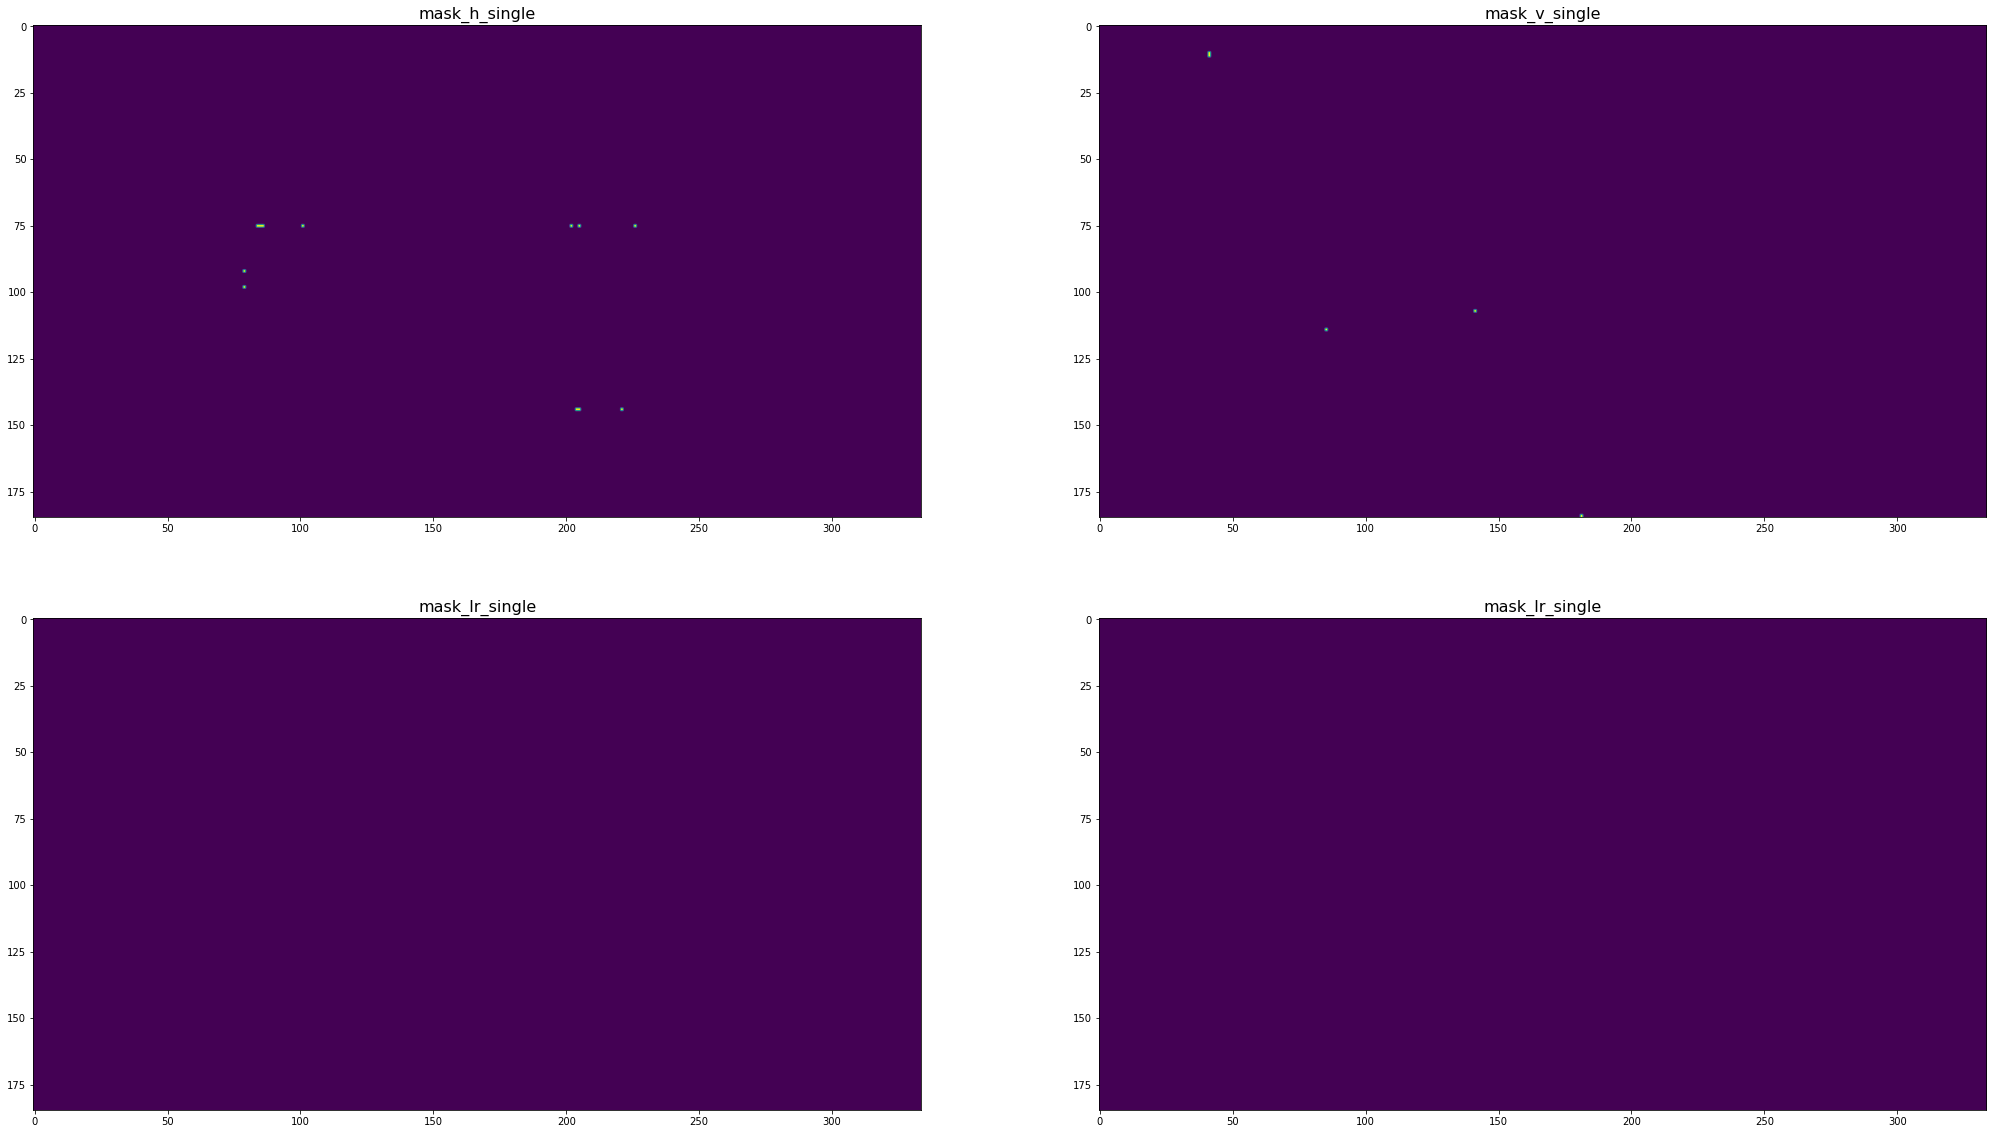

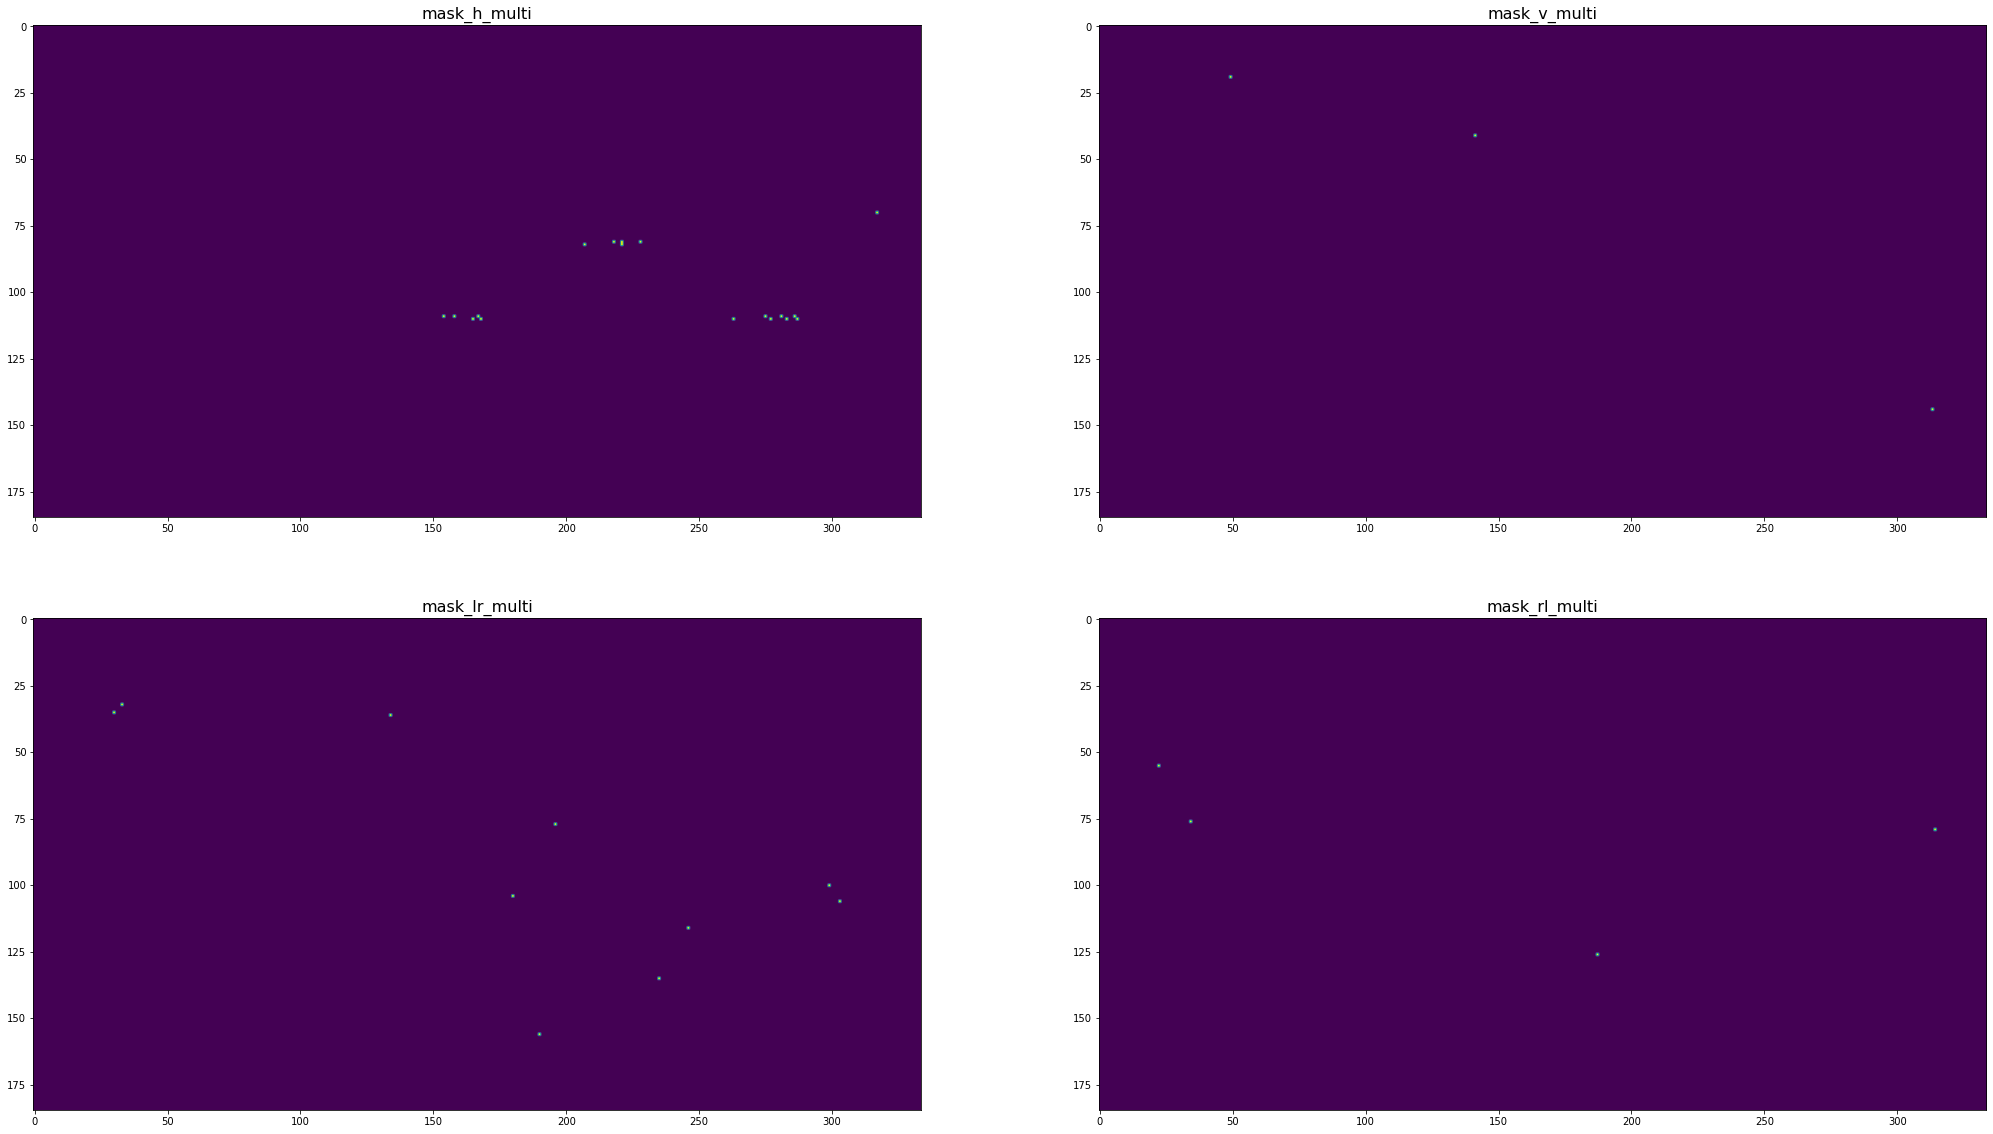

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


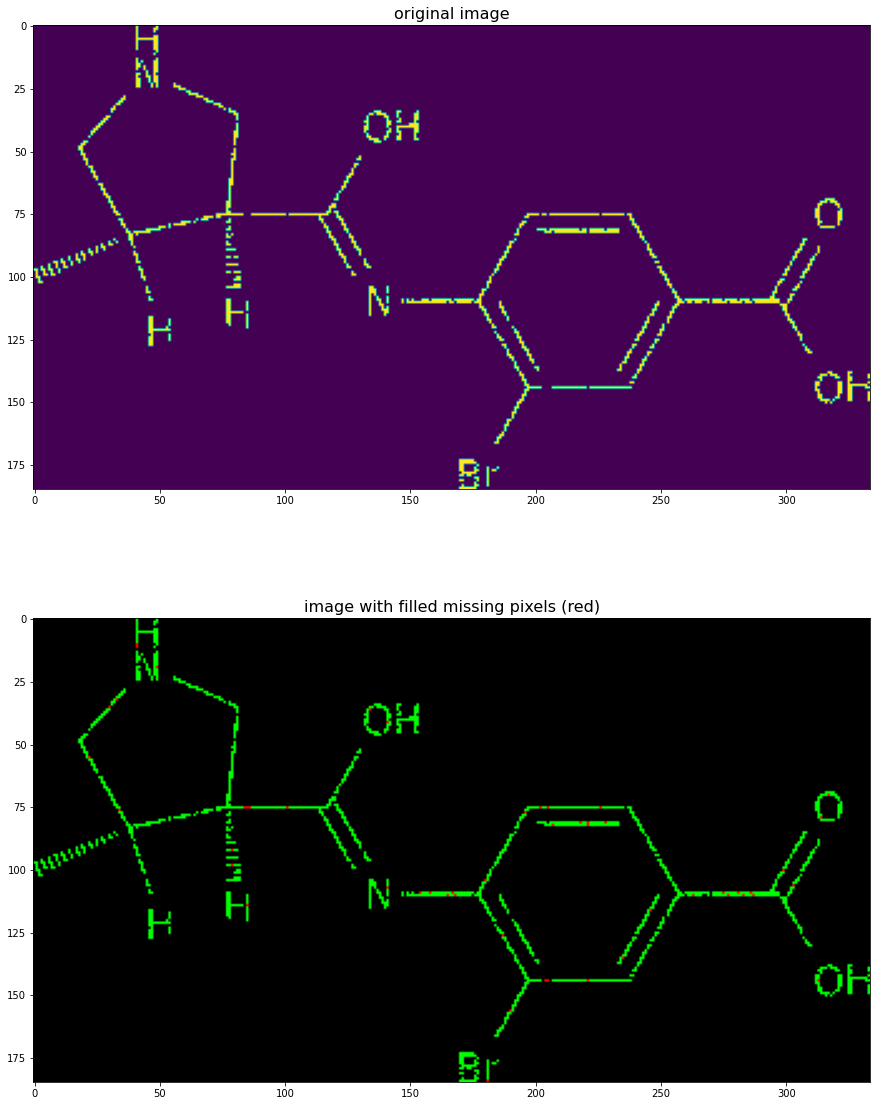

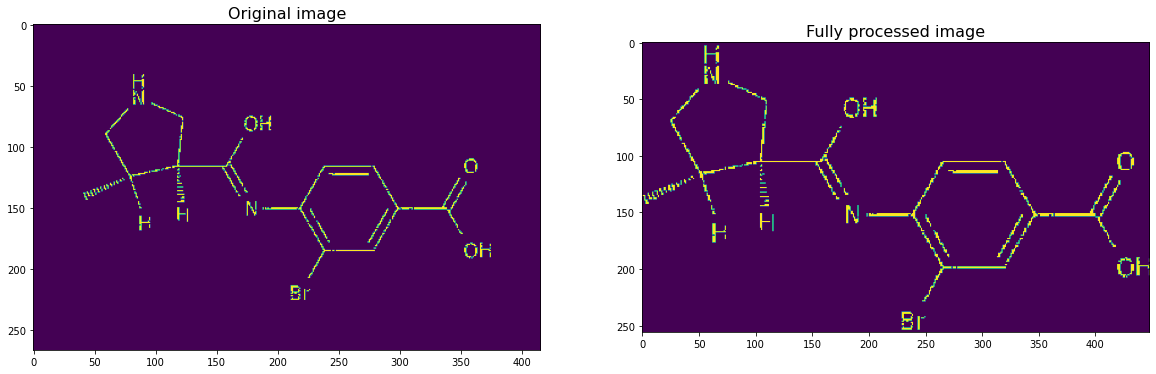

In [ ]:
process_img(train.loc[9, 'image_id'], debug=True)
pass

# Split data in chunks for TFRecords

In [ ]:
def split_in_chunks(data):
    return [data[i:i + CHUNK_SIZE] for i in range(0, len(data), CHUNK_SIZE)]

train_data_chunks = {
    'training': {
        'image_id': split_in_chunks(train['image_id'].values),
        'InChI': split_in_chunks(train['InChI_int'].values),
    },
    'val': {
        'image_id': split_in_chunks(val['image_id'].values),
        'InChI': split_in_chunks(val['InChI_int'].values),
    }
}

test_data_chunks = {
    'testing': {
        'image_id': split_in_chunks(test_mini['image_id'].values),
    }
}

In [ ]:
def make_tfrecords(data_chunks, folder='train'):
    # Try to make output folder
    try:
        os.makedirs(f'/content/drive/MyDrive/Kaggle/train/training')
        os.makedirs(f'/content/drive/MyDrive/Kaggle/train/val')
        os.makedirs(f'/content/drive/MyDrive/Kaggle/test/testing')
    except:
        print(f'folders already created')

    for k, v in data_chunks.items():
        for chunk_idx, image_id_chunk in tqdm(enumerate(v['image_id']), total=len(v['image_id'])):
            # process images in parallel
            jobs = [joblib.delayed(process_img)(fp, folder) for fp in image_id_chunk]
            bs = 10
            processed_images_chunk = joblib.Parallel(
                n_jobs=cpu_count(),
                verbose=0,
                require='sharedmem',
                batch_size=bs,
                backend='threading',
            )(jobs)

            # Create the TFRecords from the processed images
            with tf.io.TFRecordWriter(f'/content/drive/MyDrive/Kaggle/{folder}/{k}/batch_{chunk_idx}.tfrecords') as file_writer:
                if 'InChI' in v.keys(): # TRAIN/VAL, InChI included
                    for image, InChI in zip(processed_images_chunk, v['InChI'][chunk_idx]):
                        record_bytes = tf.train.Example(features=tf.train.Features(feature={
                            'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),
                            'InChI': tf.train.Feature(int64_list=tf.train.Int64List(value=InChI)),
                        })).SerializeToString()
                        file_writer.write(record_bytes)
                else: # TEST, image_id included for submission file
                    for image, image_id in zip(processed_images_chunk, image_id_chunk):
                        record_bytes = tf.train.Example(features=tf.train.Features(feature={
                            'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),
                            'image_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[str.encode(image_id)])),
                        })).SerializeToString()
                        file_writer.write(record_bytes)

make_tfrecords(train_data_chunks)
make_tfrecords(test_data_chunks, 'test')

# Check TFRecords

In [ ]:
# convert in int encoded InChI to string
def inchi_int2char(InChI):
    res = []
    for i in InChI:
        c = int_to_vocabulary.get(i)
        if c not in ['<start>', '<end>', '<pad>']:
            res.append(c)
    return ''.join(res)

In [ ]:
# Check train TFRecords
def decode_tfrecord(record_bytes):
    features = tf.io.parse_single_example(record_bytes, {
        'image': tf.io.FixedLenFeature([], tf.string),
        'InChI': tf.io.FixedLenFeature([MAX_INCHI_LEN], tf.int64),
    })

    image = tf.io.decode_jpeg(features['image'])    
    image = tf.reshape(image, [IMG_HEIGHT, IMG_WIDTH, 1])
    image = tf.cast(image, tf.float32)  / 255.0
    
    InChI = features['InChI']
    InChI = tf.reshape(InChI, [MAX_INCHI_LEN])
    
    return image, InChI

def show_tfrecords(file_path, rows=3, cols=2):
    fig, ax = plt.subplots(rows, cols, figsize=(cols*7, rows*4))
    tfrecord = tf.data.TFRecordDataset(file_path)
    for idx, (image, InChI) in enumerate(tfrecord.map(decode_tfrecord).take(rows*cols)):
        if idx == 0:
            print(f'first InChI int: {InChI}')
            print(f'first InChI char {inchi_int2char(InChI.numpy())}')
        image = tf.cast(image * 255, tf.uint8)
        image = tf.squeeze(image)
        row, col = idx // cols, idx % cols
        ax[row, col].imshow(image)

    plt.show()

print('TRAIN BATCH')
show_tfrecords(f'/content/drive/MyDrive/Kaggle/train/training/batch_0.tfrecords')
print('VAL BATCH')
show_tfrecords(f'/content/drive/MyDrive/Kaggle/train/val/batch_0.tfrecords')

TEST BATCH


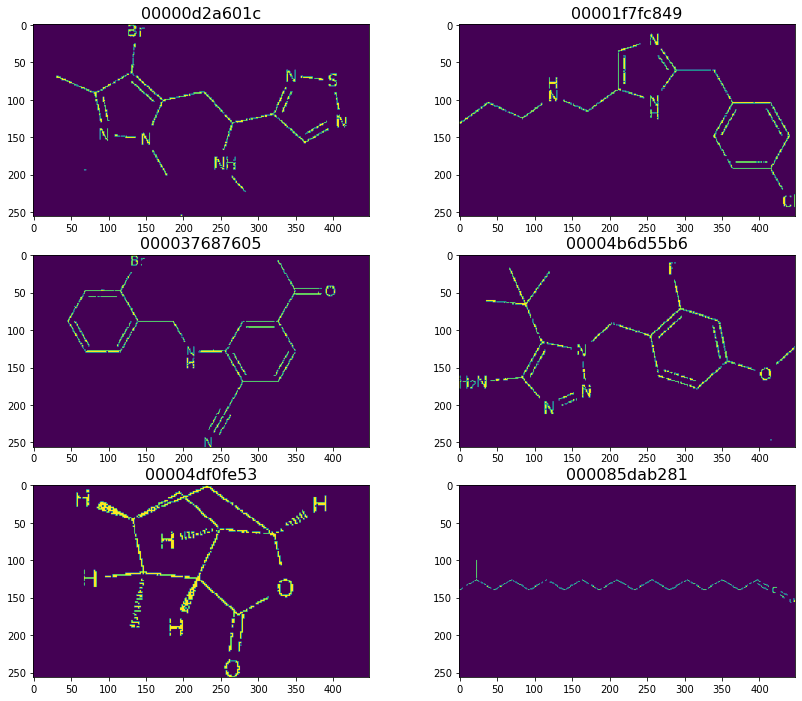

In [ ]:
# Check test TFRecords
def decode_test_tfrecord(record_bytes):
    features = tf.io.parse_single_example(record_bytes, {
        'image': tf.io.FixedLenFeature([], tf.string),
        'image_id': tf.io.FixedLenFeature([], tf.string),
    })

    image = tf.io.decode_jpeg(features['image'])
    image = tf.reshape(image, [IMG_HEIGHT, IMG_WIDTH, 1])
    image = tf.cast(image, tf.float32)  / 255.0
    
    image_id = features['image_id']
    
    return image, image_id

def show_test_tfrecords(file_path, rows=3, cols=2):
    fig, ax = plt.subplots(rows, cols, figsize=(cols*7, rows*4))
    tfrecord = tf.data.TFRecordDataset(file_path)
    for idx, (image, image_id) in enumerate(tfrecord.map(decode_test_tfrecord).take(rows*cols)):
        image = tf.cast(image * 255, tf.uint8)
        image = tf.squeeze(image)
        row, col = idx // cols, idx % cols
        ax[row, col].imshow(image)
        ax[row, col].set_title(image_id.numpy().decode(), size=16)

    plt.show()
    
print('TEST BATCH')
show_test_tfrecords(f'/content/drive/MyDrive/Kaggle/test/testing/batch_0.tfrecords')